# <center> PyABC games

In [43]:
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import sys
import math
sys.path.append('..')  # add parent directory to path to import utils
from utils import set_plots_size_params
import pyabc
import os
import scipy.stats as st
import pandas as pd
import subprocess
import time

In [44]:
def wf_with_selection_and_mutation(wt_freq, population_size, fitness, mutation_rate, sequence_sample_size):
    # math from https://academic.oup.com/sysbio/article/66/1/e30/2670014#syw056M2 
    wt_freq = wt_freq*(1 - mutation_rate) + (1 - wt_freq)*mutation_rate                  # mutation
    wt_freq = (wt_freq * fitness) / ( (1-wt_freq) + (wt_freq * fitness))                 # selection
    wt_freq = np.random.binomial(population_size, wt_freq) / population_size             # bottleneck
    return wt_freq
    
    
def wt_generations(generations_number, wt_freq, population_size, fitness, mutation_rate, sequence_sample_size, 
                   color=None, label=None, plot=True):
    freqs = []
    for i in range(generations_number):
        wt_freq = wf_with_selection_and_mutation(wt_freq=wt_freq, population_size=population_size, 
                                                 fitness=fitness, mutation_rate=mutation_rate, 
                                                 sequence_sample_size=sequence_sample_size)
        freqs.append(wt_freq)
    freqs = np.random.binomial(sequence_sample_size, freqs) / sequence_sample_size   # sequence sampling
    if plot:
        plt.plot(range(generations_number), freqs, color=color, label=label, alpha=0.1)
    return np.array(freqs)


def simulate_50(generations_number, wt_freq, population_size, fitness, mutation_rate, sequence_sample_size, 
                 color=None, label=None, plot=True):
    if plot:
        plt.xlabel('Generation')
        plt.ylabel('Frequency')
    data = []
    for i in range(50):
        datum = wt_generations(generations_number=generations_number, wt_freq=wt_freq, plot=plot,
                               population_size=population_size, fitness=fitness, mutation_rate=mutation_rate, 
                               color=color,  sequence_sample_size=sequence_sample_size, 
                               label=label if i==0 else None)
        data.append(datum)
    if label:
        leg = plt.legend()
        for lh in leg.legendHandles: 
            lh.set_alpha(1)
    return pd.DataFrame(data)

In [45]:
def pyFITS(prior_dist, data, simulation_num, params, top_fraction):
    values = []
    for i in range(simulation_num):
        prior = 10**prior_dist.rvs()['x']
        sym = wt_generations(mutation_rate=prior, generations_number=params['gen'], wt_freq=params['freq0'], 
                             population_size=params['pop'], fitness=params['fit'], 
                             sequence_sample_size=params['ss'], plot=False)
        distance = abs(sym-data).sum()
        values.append({'distance': distance, 'post': prior})
    df = pd.DataFrame.from_records(values).sort_values('distance')
    df = df.head(int(simulation_num * top_fraction))
    df['log_post'] = np.log10(df['post'])
    return df

In [46]:
def run_pyFITS(log_prior, data, num_sim, top_fraction, model_params):
    start = time.time()
    post = pyFITS(log_prior, data, num_sim, model_params, top_fraction)
    print("pyFITS run time ", round(time.time()-start,2))
    print(f"pyFITS Created posterior from {len(post)} results")
    print(f"pyFITS max epsilon: {post.distance.max()}")
    return post

In [55]:
def smc_model(parameters):
    pop_size = 100000000
    gen_num = 10
    sample_size = 100000
    intial_freq = 0
    mutation_rate = 10**parameters['x']
    fitness = 1
    return {'a': wt_generations(generations_number=gen_num,  wt_freq=intial_freq, population_size=pop_size, 
                          mutation_rate=mutation_rate, fitness=fitness, sequence_sample_size=sample_size, 
                          plot=False, color=False, label=False)}

def smc_model_fit01(parameters):
    pop_size = 100000000
    gen_num = 10
    sample_size = 100000
    intial_freq = 0
    mutation_rate = 10**parameters['x']
    fitness = 1.01
    return {'a': wt_generations(generations_number=gen_num,  wt_freq=intial_freq, population_size=pop_size, 
                          mutation_rate=mutation_rate, fitness=fitness, sequence_sample_size=sample_size, 
                          plot=False, color=False, label=False)}

In [56]:
def plot_smc(smc_out):
    fig, ax = plt.subplots()
    for t in range(smc_out.max_t+1):
        df, w = smc_out.get_distribution(m=0, t=t)
        pyabc.visualization.plot_kde_1d(
            df, w,
            x="x", ax=ax,
            label="PDF t={}".format(t))
    ax.legend(bbox_to_anchor=(1, 1))
    plt.show()


In [57]:
def last_freq_L1(simulation, data):
    return abs(data['a'] - simulation['a']).sum()

def run_smc(priors, data, epsilon, fitness):
    start = time.time()
    if fitness == 1.01:
        model = smc_model_fit01
    else:
        model = smc_model
    abc = pyabc.ABCSMC(
            model, priors,
            last_freq_L1, population_size=1000, sampler=pyabc.sampler.SingleCoreSampler())
    db_path = ("sqlite:///test.db")
    smc_post = abc.new(db_path, {'a': data})
    smc_post = abc.run(minimum_epsilon=epsilon, max_nr_populations=10)
    print("SMC run time: ", round(time.time()-start,2))
    print("Total number of SMC simulations: ", smc_post.total_nr_simulations)
    plot_smc(smc_post)
    return smc_post

In [58]:
def plot_kdes(smc_output, pyFITS_output, FITS_output, real_value):
    real_value = math.log10(real_value)
    fig, ax = plt.subplots()
    df, w = smc_output.get_distribution(m=0)
    pyabc.visualization.plot_kde_1d(
        df, w, 
        x="x", ax=ax,
        label="ABCSMC")
    ax.axvline(10**real_value, color="k", linestyle="dashed")
    pyabc.visualization.plot_kde_1d(
        pyFITS_output, np.ones(len(pyFITS_output))/len(pyFITS_output), label='pyFITS', x='log_post', ax=ax)
    ax.axvline(real_value, color="k", linestyle="dashed")
    pyabc.visualization.plot_kde_1d(
        FITS_output, np.ones(len(FITS_output))/len(FITS_output), label='FITS', x='log', ax=ax)
    plt.title('Posterior')
    plt.legend()
    return fig, ax

In [59]:
def create_fits_input_data(data):
    outfile = 'fits_input_data.tsv'
    fits = dict()
    fits['mut'] = pd.DataFrame(data={'freq': data})
    fits['wt'] = pd.DataFrame(data={'freq': 1-data})
    fits['mut']['allele'] = 1
    fits['wt']['allele'] = 0
    fits_input = pd.concat(fits.values()).reset_index().rename(columns={'index': 'gen'})
    fits_input=fits_input[['gen','allele','freq']]
    fits_input.to_csv(outfile, index=False, sep='\t')
    return outfile
    
def run_FITS(data, params_file=None):
    """FITS params need to be edited manually"""
    input_data_file = create_fits_input_data(data)
    if not params_file:
        params_file = "../FITS/parameters.txt"
    cmd = f"./../FITS/fits1.3.3 -mutation {params_file} {input_data_file} fits_post.tsv fits_sum.txt"
    start = time.time()
    subprocess.run(cmd.split())
    print("FITS run time: ", round(time.time()-start,2))
    fits_post = pd.read_table('fits_post.tsv')
    fits_post['log'] = np.log10(fits_post['allele0_1'])
    return fits_post

In [60]:
def compare_pyFITS(mutation_rate, prior_edges=[-7,-2], num_sim=100000, top_fraction=0.01, 
                   params_file=None, fitness=1):
    params = {'gen': 10, 'freq0':0, 'pop': 100000000, 'ss': 100000, 'fit': fitness}
    print("Creating dataset...")
    data = simulate_50(generations_number=params['gen'], wt_freq=params['freq0'],  mutation_rate=mutation_rate,
                       population_size=params['pop'], fitness=params['fit'], sequence_sample_size=params['ss'], 
                             plot=False).mean()
    prior_dist = pyabc.Distribution(x=pyabc.RV("uniform", prior_edges[0], prior_edges[1]-prior_edges[0]))
    print("running pyFits...")
    pyfits_out = run_pyFITS(prior_dist, data, num_sim, top_fraction, params)
    print("Running FITS...")
    fits_out = run_FITS(data, params_file)
    print("FITS max distance: ", fits_out['distance'].max())
    print("pyFITS max distance: ", pyfits_out['distance'].max())
    epsilon = pyfits_out['distance'].max()
    print("Running SMC with epsilon: ", epsilon)
    smc_out = run_smc(prior_dist, data, epsilon, fitness)
    return plot_kdes(smc_out, pyfits_out, fits_out, mutation_rate)
    

Creating dataset...
running pyFits...
pyFITS run time  38.24
pyFITS Created posterior from 1000 results
pyFITS max epsilon: 0.0025970000000000034
Running FITS...


INFO:History:Start <ABCSMC(id=148, start_time=2021-01-07 15:54:06.001477, end_time=None)>
INFO:ABC:Calibration sample before t=0.


FITS run time:  7.93
FITS max distance:  0.00453419
pyFITS max distance:  0.0025970000000000034
Running SMC with epsilon:  0.0025970000000000034


INFO:Epsilon:initial epsilon is 0.039658200000000005
INFO:ABC:t: 0, eps: 0.039658200000000005.
INFO:ABC:Acceptance rate: 1000 / 2087 = 4.7916e-01, ESS=1.0000e+03.
INFO:ABC:t: 1, eps: 0.03534819999999998.
INFO:ABC:Acceptance rate: 1000 / 2085 = 4.7962e-01, ESS=9.8719e+02.
INFO:ABC:t: 2, eps: 0.023795151891394768.
INFO:ABC:Acceptance rate: 1000 / 2153 = 4.6447e-01, ESS=9.9703e+02.
INFO:ABC:t: 3, eps: 0.013365942233383802.
INFO:ABC:Acceptance rate: 1000 / 1996 = 5.0100e-01, ESS=9.9686e+02.
INFO:ABC:t: 4, eps: 0.007029410909030223.
INFO:ABC:Acceptance rate: 1000 / 2040 = 4.9020e-01, ESS=9.9677e+02.
INFO:ABC:t: 5, eps: 0.0037758959689214383.
INFO:ABC:Acceptance rate: 1000 / 2036 = 4.9116e-01, ESS=9.9614e+02.
INFO:ABC:t: 6, eps: 0.002231800000000001.
INFO:ABC:Acceptance rate: 1000 / 2032 = 4.9213e-01, ESS=9.9893e+02.
INFO:ABC:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=148, start_time=2021-01-07 15:54:06.001477, end_time=2021-01-07 15:54:36.697567)>


SMC run time:  30.72
Total number of SMC simulations:  15429


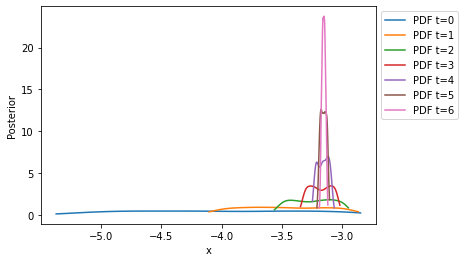

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:title={'center':'Posterior'}, xlabel='log', ylabel='Posterior'>)

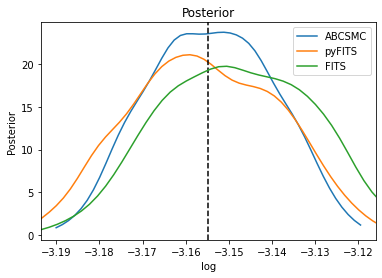

In [63]:
compare_pyFITS(0.0007, params_file='../FITS/params_fit.txt', fitness=1.01)

Creating dataset...
running pyFits...
pyFITS run time  37.66
pyFITS Created posterior from 1000 results
pyFITS max epsilon: 0.014643800000000009
Running FITS...


INFO:History:Start <ABCSMC(id=138, start_time=2021-01-07 15:12:54.559969, end_time=None)>
INFO:ABC:Calibration sample before t=0.


FITS run time:  7.7
FITS max distance:  0.0239239
pyFITS max distance:  0.014643800000000009
Running SMC with epsilon:  0.014643800000000009


INFO:Epsilon:initial epsilon is 0.2656688
INFO:ABC:t: 0, eps: 0.2656688.
INFO:ABC:Acceptance rate: 1000 / 1906 = 5.2466e-01, ESS=1.0000e+03.
INFO:ABC:t: 1, eps: 0.23803999999999978.
INFO:ABC:Acceptance rate: 1000 / 2088 = 4.7893e-01, ESS=9.7581e+02.
INFO:ABC:t: 2, eps: 0.1589792920649325.
INFO:ABC:Acceptance rate: 1000 / 2132 = 4.6904e-01, ESS=9.9876e+02.
INFO:ABC:t: 3, eps: 0.0882273359432797.
INFO:ABC:Acceptance rate: 1000 / 1979 = 5.0531e-01, ESS=9.9389e+02.
INFO:ABC:t: 4, eps: 0.04605148636720531.
INFO:ABC:Acceptance rate: 1000 / 1964 = 5.0916e-01, ESS=9.9885e+02.
INFO:ABC:t: 5, eps: 0.023153830976077722.
INFO:ABC:Acceptance rate: 1000 / 1977 = 5.0582e-01, ESS=9.9800e+02.
INFO:ABC:t: 6, eps: 0.01160572518772322.
INFO:ABC:Acceptance rate: 1000 / 2043 = 4.8948e-01, ESS=9.9912e+02.
INFO:ABC:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=138, start_time=2021-01-07 15:12:54.559969, end_time=2021-01-07 15:13:18.698356)>


SMC run time:  24.17
Total number of SMC simulations:  15089


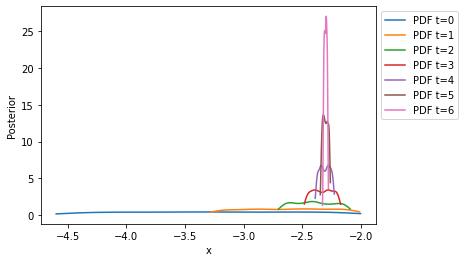

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:title={'center':'Posterior'}, xlabel='log', ylabel='Posterior'>)

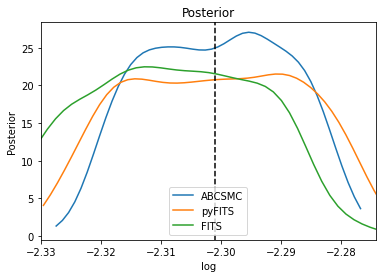

In [11]:
compare_pyFITS(0.005, [-7,-2], 100000, 0.01)

Creating dataset...
running pyFits...
pyFITS run time  41.55
pyFITS Created posterior from 1000 results
pyFITS max epsilon: 0.0006096000000000003
Running FITS...


INFO:History:Start <ABCSMC(id=139, start_time=2021-01-07 15:14:11.945910, end_time=None)>
INFO:ABC:Calibration sample before t=0.


FITS run time:  10.06
FITS max distance:  0.00113221
pyFITS max distance:  0.0006096000000000003
Running SMC with epsilon:  0.0006096000000000003


INFO:Epsilon:initial epsilon is 0.0054696
INFO:ABC:t: 0, eps: 0.0054696.
INFO:ABC:Acceptance rate: 1000 / 1954 = 5.1177e-01, ESS=1.0000e+03.
INFO:ABC:t: 1, eps: 0.0050396.
INFO:ABC:Acceptance rate: 1000 / 2098 = 4.7664e-01, ESS=9.8461e+02.
INFO:ABC:t: 2, eps: 0.003582166049864932.
INFO:ABC:Acceptance rate: 1000 / 2198 = 4.5496e-01, ESS=9.9708e+02.
INFO:ABC:t: 3, eps: 0.002029333194803806.
INFO:ABC:Acceptance rate: 1000 / 1975 = 5.0633e-01, ESS=9.9833e+02.
INFO:ABC:t: 4, eps: 0.0011114025360374246.
INFO:ABC:Acceptance rate: 1000 / 2080 = 4.8077e-01, ESS=9.9875e+02.
INFO:ABC:t: 5, eps: 0.0007530315688549202.
INFO:ABC:Acceptance rate: 1000 / 2098 = 4.7664e-01, ESS=9.8899e+02.
INFO:ABC:t: 6, eps: 0.0005979426893998021.
INFO:ABC:Acceptance rate: 1000 / 2768 = 3.6127e-01, ESS=8.2200e+02.
INFO:ABC:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=139, start_time=2021-01-07 15:14:11.945910, end_time=2021-01-07 15:14:39.267236)>


SMC run time:  27.34
Total number of SMC simulations:  16171


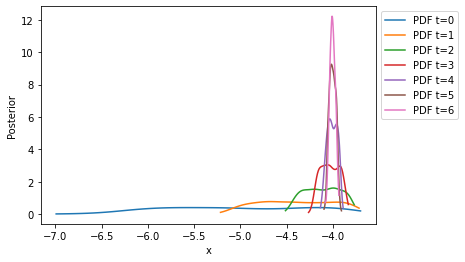

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:title={'center':'Posterior'}, xlabel='log', ylabel='Posterior'>)

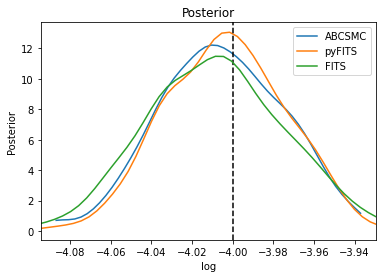

In [12]:
compare_pyFITS(0.0001, [-7,-2], 100000, 0.01)

Creating dataset...
running pyFits...
pyFITS run time  42.54
pyFITS Created posterior from 1000 results
pyFITS max epsilon: 0.0002939999999999999
Running FITS...


INFO:History:Start <ABCSMC(id=140, start_time=2021-01-07 15:15:31.769164, end_time=None)>
INFO:ABC:Calibration sample before t=0.


FITS run time:  8.22
FITS max distance:  0.000538753
pyFITS max distance:  0.0002939999999999999
Running SMC with epsilon:  0.0002939999999999999


INFO:Epsilon:initial epsilon is 0.0016672000000000002
INFO:ABC:t: 0, eps: 0.0016672000000000002.
INFO:ABC:Acceptance rate: 1000 / 1981 = 5.0480e-01, ESS=1.0000e+03.
INFO:ABC:t: 1, eps: 0.0015072000000000002.
INFO:ABC:Acceptance rate: 1000 / 2101 = 4.7596e-01, ESS=9.7884e+02.
INFO:ABC:t: 2, eps: 0.0010923510676210133.
INFO:ABC:Acceptance rate: 1000 / 2114 = 4.7304e-01, ESS=9.9205e+02.
INFO:ABC:t: 3, eps: 0.0006372000000000003.
INFO:ABC:Acceptance rate: 1000 / 2084 = 4.7985e-01, ESS=9.9874e+02.
INFO:ABC:t: 4, eps: 0.0004216000000000002.
INFO:ABC:Acceptance rate: 1000 / 2010 = 4.9751e-01, ESS=9.8696e+02.
INFO:ABC:t: 5, eps: 0.00033240000000000016.
INFO:ABC:Acceptance rate: 1000 / 2588 = 3.8640e-01, ESS=9.1803e+02.
INFO:ABC:t: 6, eps: 0.00027920000000000044.
INFO:ABC:Acceptance rate: 1000 / 4193 = 2.3849e-01, ESS=8.7283e+02.
INFO:ABC:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=140, start_time=2021-01-07 15:15:31.769164, end_time=2021-01-07 15:16:00.491876)>


SMC run time:  28.74
Total number of SMC simulations:  18071


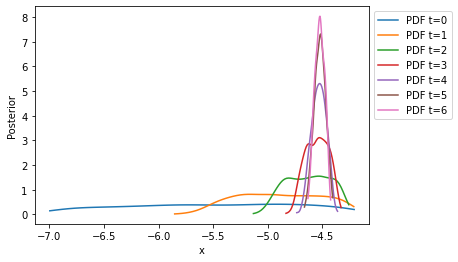

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:title={'center':'Posterior'}, xlabel='log', ylabel='Posterior'>)

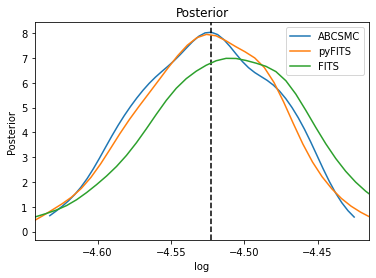

In [13]:
compare_pyFITS(0.00003, [-7,-2], 100000, 0.01)

Creating dataset...
running pyFits...
pyFITS run time  44.1
pyFITS Created posterior from 1000 results
pyFITS max epsilon: 5.660000000000004e-05
Running FITS...


INFO:History:Start <ABCSMC(id=141, start_time=2021-01-07 15:16:55.409136, end_time=None)>
INFO:ABC:Calibration sample before t=0.


FITS run time:  8.87
FITS max distance:  0.000102401
pyFITS max distance:  5.660000000000004e-05
Running SMC with epsilon:  5.660000000000004e-05


INFO:Epsilon:initial epsilon is 0.0019183999999999963
INFO:ABC:t: 0, eps: 0.0019183999999999963.
INFO:ABC:Acceptance rate: 1000 / 1921 = 5.2056e-01, ESS=1.0000e+03.
INFO:ABC:t: 1, eps: 0.00010660000000000007.
INFO:ABC:Acceptance rate: 1000 / 1877 = 5.3277e-01, ESS=9.8939e+02.
INFO:ABC:t: 2, eps: 8.860000000000007e-05.
INFO:ABC:Acceptance rate: 1000 / 2119 = 4.7192e-01, ESS=9.4993e+02.
INFO:ABC:t: 3, eps: 7.820000000000006e-05.
INFO:ABC:Acceptance rate: 1000 / 3037 = 3.2927e-01, ESS=9.1795e+02.
INFO:ABC:t: 4, eps: 6.900000000000002e-05.
INFO:ABC:Acceptance rate: 1000 / 4471 = 2.2366e-01, ESS=4.3197e+02.
INFO:ABC:t: 5, eps: 6.3e-05.
INFO:ABC:Acceptance rate: 1000 / 7274 = 1.3748e-01, ESS=8.4201e+02.
INFO:ABC:t: 6, eps: 5.620000000000003e-05.
INFO:ABC:Acceptance rate: 1000 / 13760 = 7.2674e-02, ESS=5.8688e+02.
INFO:ABC:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=141, start_time=2021-01-07 15:16:55.409136, end_time=2021-01-07 15:17:45.633862)>


SMC run time:  50.25
Total number of SMC simulations:  35459


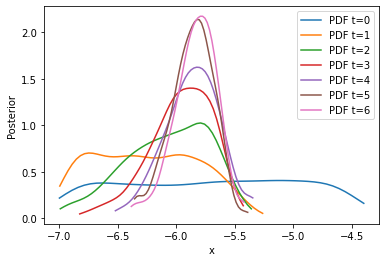

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:title={'center':'Posterior'}, xlabel='log', ylabel='Posterior'>)

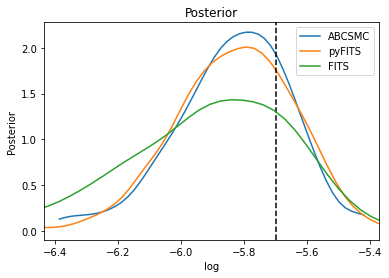

In [14]:
compare_pyFITS(0.000002, [-7,-2], 100000, 0.01)

Creating dataset...
running pyFits...
pyFITS run time  37.62
pyFITS Created posterior from 1000 results
pyFITS max epsilon: 1.86e-05
Running FITS...


INFO:History:Start <ABCSMC(id=144, start_time=2021-01-07 15:24:06.800803, end_time=None)>
INFO:ABC:Calibration sample before t=0.


FITS run time:  8.16
FITS max distance:  3.6e-05
pyFITS max distance:  1.86e-05
Running SMC with epsilon:  1.86e-05


INFO:Epsilon:initial epsilon is 0.002076399999999996
INFO:ABC:t: 0, eps: 0.002076399999999996.
INFO:ABC:Acceptance rate: 1000 / 1916 = 5.2192e-01, ESS=1.0000e+03.
INFO:ABC:t: 1, eps: 0.00010539999999999999.
INFO:ABC:Acceptance rate: 1000 / 2092 = 4.7801e-01, ESS=9.6079e+02.
INFO:ABC:t: 2, eps: 3.3e-05.
INFO:ABC:Acceptance rate: 1000 / 2045 = 4.8900e-01, ESS=9.8693e+02.
INFO:ABC:t: 3, eps: 2.3000000000000003e-05.
INFO:ABC:Acceptance rate: 1000 / 2465 = 4.0568e-01, ESS=9.0878e+02.
INFO:ABC:t: 4, eps: 1.86e-05.
INFO:ABC:Acceptance rate: 1000 / 3026 = 3.3047e-01, ESS=6.3316e+02.
INFO:ABC:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=144, start_time=2021-01-07 15:24:06.800803, end_time=2021-01-07 15:24:27.616480)>


SMC run time:  20.84
Total number of SMC simulations:  12544


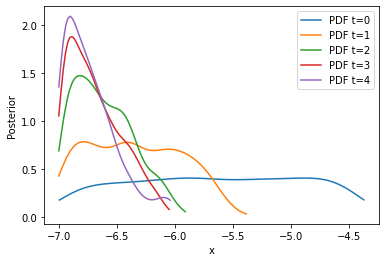

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:title={'center':'Posterior'}, xlabel='log', ylabel='Posterior'>)

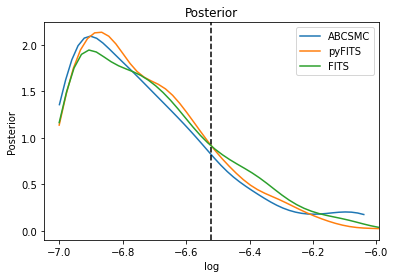

In [18]:
compare_pyFITS(0.0000003, [-7,-2], 100000, 0.01)

In [15]:
THE END!

SyntaxError: invalid syntax (<ipython-input-15-cd9185eb4cf5>, line 1)

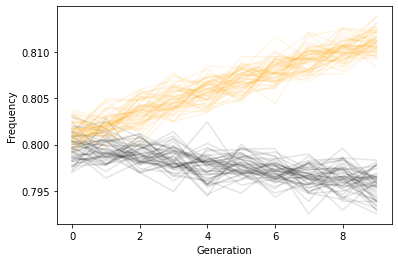

In [37]:
pop_size = 100000000
gen_num = 10
fitness = 1
mutation_rate = 0.0007
sample_size = 100000
intial_freq = 0.8
data = simulate_50(generations_number=gen_num, wt_freq=intial_freq, population_size=pop_size,
                             fitness=fitness, mutation_rate=mutation_rate, sequence_sample_size=sample_size, 
                             color='black').mean()
fitness = 1.01
data = simulate_50(generations_number=gen_num, wt_freq=intial_freq, population_size=pop_size,
                             fitness=fitness, mutation_rate=mutation_rate, sequence_sample_size=sample_size, 
                             color='orange').mean()


# From here onwards its legacy code! Continue at your own risk!

In [ ]:
compare_pyFITS(0.00002, [-7,-2], 100000, 0.01)

In [ ]:
pop_size = 100000000
gen_num = 10
fitness = 1
mutation_rate = 0.0003
sample_size = 100000
intial_freq = 0
data = simulate_50(generations_number=gen_num, wt_freq=intial_freq, population_size=pop_size,
                             fitness=fitness, mutation_rate=mutation_rate, sequence_sample_size=sample_size, 
                             color='black').mean()
fits = dict()
fits['mut'] = pd.DataFrame(data={'freq': data})
fits['wt'] = pd.DataFrame(data={'freq': 1-data})
fits['mut']['allele'] = 1
fits['wt']['allele'] = 0
fits_input = pd.concat(fits.values()).reset_index().rename(columns={'index': 'gen'})
fits_input=fits_input[['gen','allele','freq']]
#fits_input.to_csv('fits_input_3e4.tsv', index=False, sep='\t')

In [ ]:
fits = dict()
fits['mut'] = pd.DataFrame(data={'freq': data.mean()})
fits['wt'] = pd.DataFrame(data={'freq': 1-data.mean()})
fits['mut']['allele'] = 1
fits['wt']['allele'] = 0
fits_input = pd.concat(fits.values()).reset_index().rename(columns={'index': 'gen'})
fits_input=fits_input[['gen','allele','freq']]
#fits_input.to_csv('fits_input_01.tsv', index=False, sep='\t')

In [ ]:
data.mean().values

In [ ]:
fits_post = pd.read_table('../FITS/posterior.txt')
#narr_pri = pd.read_table('../FITS/post_narrow_prior.txt')
bottle_post = pd.read_table('../FITS/post_bottle.tsv')
fits_mil = pd.read_table('../FITS/post_mil.tsv')

In [ ]:
fits_post = pd.read_table('../FITS/posterior.txt')
fits_post['log'] = np.log10(fits_post['allele0_1'])

In [ ]:
epsilon = fits_post.distance.max()
epsilon

In [ ]:
post_01 = pd.read_table('../FITS/post_01.tsv')
post_01['log'] = np.log10(post_01['allele0_1'])

In [ ]:
epsilon = post_01.distance.max()
epsilon

In [ ]:
def estimate_post_in_point(point):
    post = 0
    for i in range(1000):
        syn_data = model({'x':point})
        dist = last_freq_L1(syn_data, {'a': y_observed})
        if dist < epsilon:
            post += 1
    return post

In [ ]:
post = []
rates = []
start= -4
for i in range(100):
    rate = start + (i/100)
    rates.append(round(rate,3))
    post.append(estimate_post_in_point(rate))

In [ ]:
plt.plot(post)

In [ ]:
test = pd.DataFrame.from_dict(data=post, orient='index')

In [ ]:
plt.hist(post)

In [ ]:
post

In [ ]:
history.total_nr_simulations


In [ ]:
observation = mutation_rate
fig, ax = plt.subplots()
for t in range(history.max_t+1):
    df, w = history.get_distribution(m=0, t=t)
    pyabc.visualization.plot_kde_1d(
        df, w,
        xmin=-5, xmax=-2,
        x="x", ax=ax,
        label="PDF t={}".format(t))
ax.axvline(observation, color="k", linestyle="dashed")
ax.legend(bbox_to_anchor=(1, 1))


In [ ]:
fits_mil['log'] = np.log10(fits_mil['allele0_1'])

In [ ]:
fig, ax = plt.subplots()
df, w = history.get_distribution(m=0)
pyabc.visualization.plot_kde_1d(
    df, w, 
    xmin=-4, xmax=-3,
    x="x", ax=ax,
    label="ABCSMC".format(t))
ax.axvline(10**observation, color="k", linestyle="dashed")
"""pyabc.visualization.plot_kde_1d(
    fits_post, np.ones(1000)/1000, label='FITS', x='log',
    xmin=-4, xmax=-3, ax=ax)
"""
pyabc.visualization.plot_kde_1d(
    fits_mil, np.ones(10000)/10000, label='FITS-million', x='log',
    xmin=-4, xmax=-3, ax=ax)
#plt.plot(test.rate, test.freq/60, label='Model')   # <--- ignore the height this is just to normalize.
plt.title('Posterior')
plt.legend()

In [ ]:
asdasd

In [ ]:
fig, ax = plt.subplots()
df, w = history.get_distribution(m=0)
pyabc.visualization.plot_kde_1d(
    df, w, 
    xmin=-3.5, xmax=-2.5,
    x="x", ax=ax,
    label="ABCSMC")
ax.axvline(-3, color="k", linestyle="dashed")
pyabc.visualization.plot_kde_1d(
    post_01, np.ones(10000)/10000, label='FITS-01', x='log',
    xmin=-3.5, xmax=-2.5, ax=ax)
#plt.plot(test.rate, test.freq/60, label='Model')   # <--- ignore the height this is just to normalize.
plt.title('Posterior')
plt.legend()

In [ ]:
# TODO: build wrapper and compare different mutation rates and params

In [ ]:
narr_pri['log'] = np.log10(narr_pri['allele0_1'])

In [ ]:
bottle_post['log'] = np.log10(bottle_post['allele0_1'])

In [ ]:
fits_post.distance.max()

In [ ]:
fits_post['log'] = np.log10(fits_post['allele0_1'])

In [ ]:
fits_post['log'].min(),fits_post['log'].max()

In [ ]:
df['x'].min(),df['x'].max()

In [ ]:
len(w)

In [ ]:
len(fits_post['log'])

In [ ]:
fits_post

In [ ]:
fig, ax = plt.subplots()
df, w = history.get_distribution(m=0)
pyabc.visualization.plot_kde_1d(
    df, w, 
    xmin=-4, xmax=-3,
    x="x", ax=ax,
    label="ABCSMC".format(t))
ax.axvline(observation, color="k", linestyle="dashed")
"""pyabc.visualization.plot_kde_1d(
    fits_post, np.ones(1000)/1000, label='FITS', x='log',
    xmin=-4, xmax=-3, ax=ax)
"""
pyabc.visualization.plot_kde_1d(
    bottle_post, np.ones(1000)/1000, label='FITS-bottle', x='log',
    xmin=-4, xmax=-3, ax=ax)
#plt.plot(test.rate, test.freq/60, label='Model')   # <--- ignore the height this is just to normalize.
plt.title('Posterior')
plt.legend()

In [ ]:
test = pd.DataFrame(data={'rate': rates, 'freq': post})

In [ ]:
test.loc[50]

In [ ]:
plt.plot(test.rate, test.freq/50)

In [ ]:
pyabc.visualization.plot_kde_1d(
    test, np.ones(100), label='FITS-narrow', x='rate',
    xmin=-4, xmax=-3)


In [ ]:
plt.hist(df.x, weights=w)


In [ ]:
plt.hist(fits_post.log)
#fits_post.log.hist()

In [ ]:
def sample_over_threshold(x, eps, min_prior, max_prior):
    res = []
    for i in range(10000):
        y = np.random.uniform(min_prior,max_prior)
        if abs(y - x) < eps:
            res.append(y)
    return res

In [ ]:
narrow_sample = sample_over_threshold(1000, 10, 900, 1100)
wide_sample = sample_over_threshold(1000, 10, 0, 2000)

In [ ]:
plt.hist(wide_sample)

In [ ]:
plt.hist(narrow_sample)

In [ ]:
min(narrow_sample), max(narrow_sample)

In [ ]:
min(wide_sample), max(wide_sample)

In [ ]:
np.random.uniform(990,1010)

In [ ]:
np.random.uniform(0,2000)

In [ ]:
fits_post['allele0_1']

In [ ]:
sns.kdeplot(fits_post['allele0_1'])
plt.axvline(observation, color="k", linestyle="dashed");

In [ ]:
fits_post.distance.hist()

In [ ]:
fits_post.distance.mean()

In [ ]:
fits_post['allele1_0'].max()

In [ ]:
fits_post['allele1_0'].min()

In [ ]:
import seaborn as sns
sns.kdeplot(history.get_distribution(m=0)[1])
plt.axvline(observation, color="k", linestyle="dashed");

In [ ]:
observation

In [ ]:
plt.hist(history.get_distribution(m=0)[1], )

In [ ]:
samples, weights = history.get_distribution(m=0)
samples.hist(weights=weights)
print(np.average(samples.x, weights=weights))

In [ ]:
adasdasd

In [ ]:
samples.hist()

In [ ]:
sns.kdeplot(samples.x, weights=weights)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
samples_, weights_ = history.get_distribution(m=0)
pyabc.visualization.plot_kde(
    samples_, weights_, ax=ax)
"""ax.plot(μ, σ, '*', color=color_truth)
ax.plot(μ_hat, σ_hat, '*', color=color_estimate)
"""

In [ ]:
samples.x

In [ ]:
np.average(samples.x, weights=weights)


In [ ]:
import seaborn as sns
sns.boxplot(samples)

In [ ]:
samples.x.std()

In [ ]:
history.get_distribution(m=1)

In [ ]:
model(mutation_rate=mutation_rate)[9]

In [ ]:
np.mean(model(mutation_rate=mutation_rate))

In [ ]:
set_plots_size_params(20)

In [ ]:
sigma = .5

def model(parameters):
    # sample from a gaussian
    y = st.norm(parameters.x, sigma).rvs()
    # return the sample as dictionary
    return {"y": y}

models = [model, model]


# However, our models' priors are not the same.
# Their mean differs.
mu_x_1, mu_x_2 = 0, 1
parameter_priors = [
    pyabc.Distribution(x=pyabc.RV("norm", mu_x_1, sigma)),
    pyabc.Distribution(x=pyabc.RV("norm", mu_x_2, sigma))
]
abc = pyabc.ABCSMC(
    models, parameter_priors,
    pyabc.PercentileDistance(measures_to_use=["y"]))
# y_observed is the important piece here: our actual observation.
y_observed = 1
# and we define where to store the results
db_path = ("sqlite:///test.db")
history = abc.new(db_path, {"y": y_observed})


In [ ]:
# We run the ABC until either criterion is met
history = abc.run(minimum_epsilon=0.1, max_nr_populations=5)


In [ ]:
model_probabilities = history.get_model_probabilities()
model_probabilities
